# Settings and Imports

In [ ]:
!pip install surprise

In [ ]:
import pandas as pd 
import numpy as np
from collections import defaultdict
import pickle

from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split

## Dataset

In [ ]:
ratings = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/data/movies/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
print("Total number of records:", len(ratings))
print("Number of unique users:", len(ratings.userId.unique()))
print("Number of unique movies:", len(ratings.movieId.unique()))

Total number of records: 100004
Number of unique users: 671
Number of unique movies: 9066


In [ ]:
movies = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/data/movies/movies_metadata.csv', low_memory=False)
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## Prepare data for surprise

In [ ]:
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Baseline classifier

In [ ]:
trainset, testset = train_test_split(data, test_size=.2, random_state=42)
algo = SVD()

False


In [ ]:
cross_validate(algo, data, measures = ['RMSE', 'MAE'], cv = 3, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9038  0.8967  0.9080  0.9028  0.0047  
MAE (testset)     0.6968  0.6898  0.6987  0.6951  0.0038  
Fit time          4.20    4.10    4.18    4.16    0.04    
Test time         0.28    0.29    0.40    0.32    0.06    


{'fit_time': (4.199181079864502, 4.104192018508911, 4.1750617027282715),
 'test_mae': array([0.69676532, 0.68984796, 0.69874343]),
 'test_rmse': array([0.90376093, 0.89670132, 0.90804132]),
 'test_time': (0.27787303924560547, 0.2867257595062256, 0.40204858779907227)}

In [ ]:
algo.fit(trainset)

In [ ]:
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9012


0.9011855362236062

In [ ]:
uid = 1
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
# get a prediction for specific users and items.
algo.predict(uid, 302)

Prediction(uid=1, iid=302, r_ui=None, est=2.8666020096326807, details={'was_impossible': False})

# Grid Search CV

In [ ]:
param_grid = {'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005, 0.008],
              'reg_all': [0.2, 0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures = ['RMSE', 'MAE'], cv = 3)

gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8970623695275625
{'n_epochs': 15, 'lr_all': 0.008, 'reg_all': 0.2}


In [ ]:
algo = gs.best_estimator['rmse']
algo.fit(data.build_full_trainset())

# API

In [ ]:
def get_top_n(predictions, n = 10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

In [ ]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [ ]:
top_n = get_top_n(predictions, n=10)

# # Print the recommended items for each user
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])

## Get top 10 recommendations per user
Given a user

In [ ]:
top_n[1]

[(7502, 3.6549001458832375),
 (1212, 3.6224327459600016),
 (1217, 3.6223186532253853),
 (858, 3.61516737901969),
 (1219, 3.579817546669988),
 (5995, 3.5784258970373632),
 (48516, 3.575476137695213),
 (3035, 3.567122143728089),
 (2064, 3.551548169322184),
 (1201, 3.5364626406430544)]

In [ ]:
top_n[2]
# movie id, predicted rating

[(899, 4.443233670329531),
 (1212, 4.397175422690432),
 (969, 4.381537427493032),
 (904, 4.370810051652229),
 (318, 4.362856631042568),
 (913, 4.3616920930178384),
 (6787, 4.357325223829409),
 (1221, 4.351347430201646),
 (1252, 4.345143364182624),
 (1217, 4.339924435749329)]

## Get predicted movie rating

Given a user and a movie

In [ ]:
algo.predict(2, 904)
# est is the predicted rating

Prediction(uid=2, iid=904, r_ui=None, est=4.370810051652229, details={'was_impossible': False})

## Exporting

In [ ]:
# saving the top_n for all users
pickle.dump(top_n, open("top_n.data", "wb"))

In [ ]:
# saving the model
pickle.dump(algo, open("svd.data", "wb"))

## Importing

In [ ]:
new_top_n = pickle.load(open("top_n.data", "rb"))
new_top_n[1]

[(7502, 3.6549001458832375),
 (1212, 3.6224327459600016),
 (1217, 3.6223186532253853),
 (858, 3.61516737901969),
 (1219, 3.579817546669988),
 (5995, 3.5784258970373632),
 (48516, 3.575476137695213),
 (3035, 3.567122143728089),
 (2064, 3.551548169322184),
 (1201, 3.5364626406430544)]

In [ ]:
new_algo = pickle.load(open("svd.data", "rb"))
algo.predict(2, 904)

Prediction(uid=2, iid=904, r_ui=None, est=4.370810051652229, details={'was_impossible': False})

## Additional work

In [ ]:
new_algo = pickle.load(open("/content/drive/My Drive/Colab_Notebooks/data/movies/mydata/svd.data", "rb"))

In [ ]:
new_algo.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=2.6829404522529354, details={'was_impossible': False})

In [ ]:
movies[movies['id'] == '302'].title

6389    Swimming Pool
Name: title, dtype: object

In [ ]:
ratings[ratings['movieId'] == 302]

,userId,movieId,rating,timestamp
13375,86,302,3.0,848161134
31298,224,302,4.0,828214012
54695,391,302,4.0,891533396
55143,396,302,4.0,834999154
73529,514,302,3.0,853893761
82993,564,302,4.0,974841654
91822,608,302,4.0,939461651


# Neural Netwrok

## Main Module
The steps in the model are as follows:
1. Map user ID to a "user vector" via an embedding matrix
1.  Map movie ID to a "movie vector" via an embedding matrix
1. Compute the dot product between the user vector and movie vector, to obtain the a match score between the user and the movie (predicted rating).
1. Train the embeddings via gradient descent using all known user-movie pairs.

### Imports

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

### Dealing with Data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/data/movies/ratings_small.csv')

In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 671, Number of Movies: 9066, Min rating: 0.5, Max rating: 5.0


In [138]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

### Define the NN model

In [139]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [140]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
              optimizer = keras.optimizers.Adam(lr = 0.001))

### Train the model

In [141]:
history = model.fit(x = x_train, 
                    y = y_train,
                    batch_size = 64, 
                    epochs = 5, 
                    verbose = 1,
                    validation_data=(x_val, y_val))

Epoch 1/5
1407/1407 [==============================] - 5s 4ms/step - loss: 0.6319 - val_loss: 0.6138
Epoch 2/5
1407/1407 [==============================] - 5s 4ms/step - loss: 0.6074 - val_loss: 0.6101
Epoch 3/5
1407/1407 [==============================] - 5s 4ms/step - loss: 0.6025 - val_loss: 0.6057
Epoch 4/5
1407/1407 [==============================] - 5s 4ms/step - loss: 0.6013 - val_loss: 0.6031
Epoch 5/5
1407/1407 [==============================] - 5s 4ms/step - loss: 0.6014 - val_loss: 0.6028


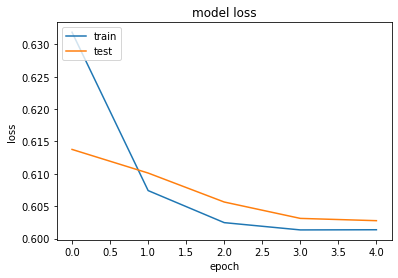

In [142]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

### Making predictions

In [159]:
user_id = 1
movies_not_watched = [904]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
rating = model.predict(user_movie_array)
r = rating[0][0]
f = r * max_rating
f

2.8040897846221924

## Another try

In [ ]:
n_latent_factors_user = 8
n_latent_factors_movie = 10
n_latent_factors_mf = 3         # Matrix Factorization
dropout_factor = 0.2

In [ ]:
movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
movie_vec_mlp = keras.layers.Dropout(dropout_factor)(movie_vec_mlp)

movie_embedding_mf = keras.layers.Embedding(n_movies + 1, n_latent_factors_mf, name='Movie-Embedding-MF')(movie_input)
movie_vec_mf = keras.layers.Flatten(name='FlattenMovies-MF')(movie_embedding_mf)
movie_vec_mf = keras.layers.Dropout(dropout_factor)(movie_vec_mf)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)


concat = keras.layers.merge([movie_vec_mlp, user_vec_mlp], mode='concat',name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat_dropout)
dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(dropout_1)
dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)


dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

pred_mf = keras.layers.merge([movie_vec_mf, user_vec_mf], mode='dot',name='Dot')


pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

combine_mlp_mf = keras.layers.merge([pred_mf, pred_mlp], mode='concat',name='Concat-MF-MLP')
result_combine = keras.layers.Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(100,name='FullyConnected-4')(result_combine)


result = keras.layers.Dense(1,name='Prediction')(deep_combine)


model = keras.Model([user_input, movie_input], result)
opt = keras.optimizers.Adam(lr =0.01)
model.compile(optimizer='adam',loss= 'mean_absolute_error')

[[3.0], [5.0], [5.0], [5.0], [5.0], [3.5], [4.0], [4.0], [3.0], [3.5]]

References:
* https://surprise.readthedocs.io/en/stable/getting_started.html
* https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
* https://www.kaggle.com/rounakbanik/movie-recommender-systems
* https://www.kaggle.com/fabiendaniel/film-recommendation-engine
* https://www.kaggle.com/fabiendaniel/film-recommendation-engine
* https://surprise.readthedocs.io/en/stable/FAQ.html
* https://surprise.readthedocs.io/en/stable/matrix_factorization.html?highlight=svd#surprise.prediction_algorithms.matrix_factorization.SVD
* https://wiki.python.org/moin/UsingPickle
* https://keras.io/examples/structured_data/collaborative_filtering_movielens/
* https://colab.research.google.com/github/nipunbatra/blog/blob/master/_notebooks/2017-12-29-neural-collaborative-filtering.ipynb#scrollTo=AYejMFoinQad
* https://towardsdatascience.com/paper-review-neural-collaborative-filtering-explanation-implementation-ea3e031b7f96
